## MERGING BOTH DATASETS

In [1]:
from os import listdir
from os.path import isfile, join

import re
from itertools import combinations
from itertools import chain

import pandas as pd
import numpy as np

import geopandas as gpd
import geojson
import rtree

import folium.folium

import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium import plugins

%matplotlib inline

pd.set_option('display.max_rows', 1000)

## DEF AND GLOBAL VARIABLES

In [35]:
# GLOBAL variables
CLEAN_PATH = '../data/clean' # transform this into temp file

NAMES_DICT = {
    
    'build_gdf': 'bu_point',
    'arturo_gdf': 'qlity_mdl',
}

MADRID_EPSG = 25830
STATE = 42

In [3]:
def value_propagation(gdf_wbuffer, cols_wbuffer,
                      gdf_tomerge, cols_tomerge,
                      geometry_col, value_col, 
                      buffer_res, dist_to_propagate):
    """
    Note__________________________________________________
    Cambiar en el archivo de ARTURO MODEL para unificar
    """    
    # variables

    
    gdf_wbuffer['buffer_geom'] = gdf_wbuffer[geometry_col].buffer(distance = dist_to_propagate, 
                                                                resolution = buffer_res)
    # Making GeoDF
    cols_buffer = cols_wbuffer + ['buffer_geom']
    
    aux_gdf = gpd.GeoDataFrame(gdf_wbuffer[cols_buffer],
                    geometry = gdf_wbuffer['buffer_geom'])

    # Spacial Union 
    cols_geom = cols_tomerge + [geometry_col]
    points_gdf = gpd.sjoin(gdf_tomerge[cols_geom], 
                           aux_gdf, 
                           how='inner', 
                           op='within')
    
    cols_all = cols_wbuffer + cols_tomerge
    points_gdf.groupby(by = ['buffer_geom'], dropna = True) # geometry from build_gdf
    points_gdf = points_gdf[cols_all]

    ## Merging and cleaning the mess
    final_gdf = gdf_tomerge.merge(points_gdf.groupby(by = ['ID']).mean().reset_index(), 
                                  how = 'left', left_on = 'ID', right_on = 'ID')
    

    return final_gdf

def year_to_halfcentury(year):
    """
    esta función debería estar quizá en el primer pipeline
    """
    
    if 0      < int(year) <= 500:  return '00-05'
    elif 500  < int(year) <= 1400: return '05-14'
    elif 1400 < int(year) <= 1600: return '14-16'
    elif 1600 < int(year) <= 1750: return '18-01'
    elif 1750 < int(year) <= 1800: return '18-02'
    elif 1800 < int(year) <= 1850: return '19-01'
    elif 1850 < int(year) <= 1900: return '19-02'
    elif 1900 < int(year) <= 1950: return '20-01'
    elif 1950 < int(year) <= 2000: return '20-02'
    elif 2000 < int(year) <= 2050: return '21-01'
    else: return 'unknown'

In [4]:
# Open files in directory
all_raw_geofiles = [f for f in listdir(CLEAN_PATH) if isfile(join(CLEAN_PATH, f))]
all_raw_geofiles

['building_points.geojson', 'building_polygon.geojson', 'arturo.geojson']

In [5]:
# Opening and naming
build_gdf = gpd.read_file(f"{CLEAN_PATH}/building_points.geojson")
build_gdf.name = NAMES_DICT['build_gdf']

arturo_gdf = gpd.read_file(f"{CLEAN_PATH}/arturo.geojson")
arturo_gdf.name = NAMES_DICT['arturo_gdf']

In [6]:
# CHecking both GeoDataFrames have the same proyection
build_gdf = build_gdf.set_crs(epsg = MADRID_EPSG, allow_override = True)
arturo_gdf = arturo_gdf.set_crs(epsg = MADRID_EPSG, allow_override = True)

In [7]:
display(build_gdf.head(2))
display(build_gdf.shape)

display(arturo_gdf.head(2))
display(arturo_gdf.shape)

ID conditionOfConstruction   currentUse yearOfConstruction  \
0  000200100VK48E              functional  agriculture               1968   
1  000200500VK56E                declined   industrial               1995   

   n_BuildingUnits  n_Dwellings  nFloors_AG  nFloors_BG  ID_part  area_m2c  \
0                1            0           1           0        1        26   
1                1            0           1           0        2       646   

   area_m2p                        geometry  
0        26  POINT (441654.170 4487048.360)  
1      1268  POINT (451607.030 4467199.270)

(122153, 12)

OGC_FID dist_barri dm_id  train  land_use_mix  closeness_small_parks  \
0       6       0907     6      0      0.000032                  500.0   
1       7       1303     7      0      0.000136                  500.0   

   residence_ratio   block_area  intersection_density  anisotropicity  ...  \
0          0.85614  4671.285714              0.082709        0.201134  ...   
1          0.90265  1048.000000              0.806187        0.056678  ...   

   street_centrality_eigenvector  street_centrality_betweenness  \
0                            0.0                       0.000058   
1                            0.0                       0.000109   

   street_centrality_closeness  street_hierarchy_primary  \
0                     0.017218                         0   
1                     0.015509                         0   

   street_hierarchy_secondary  street_hierarchy_tertiary  pk      value  \
0                           0                          1   6  26.165229   
1                           0                          1   7  33.917480   

   dm_id_num                        geometry  
0        NaN  POINT (432684.839 4479596.895)  
1        NaN  POINT (444179.509 4471301.355)  

[2 rows x 60 columns]

(28753, 60)

In [8]:
buil_f_gdf = value_propagation( gdf_wbuffer = arturo_gdf,
                              cols_wbuffer = [col for col in arturo_gdf.columns.tolist() \
                                                  if arturo_gdf[col].dtype != 'O' and \
                                                    (arturo_gdf[col].dtype == 'float64' or\
                                                     arturo_gdf[col].dtype == 'int64')],
                              gdf_tomerge = build_gdf,                      
                              cols_tomerge = ['ID'],
                              geometry_col = 'geometry', 
                              value_col = 'value', 
                              buffer_res = 25, 
                              dist_to_propagate = 100)

In [9]:
print(f"Shape: \t\t\t\t{buil_f_gdf.shape} (rows, cols)")
print(f"Not null values: \t\t{buil_f_gdf['value'].notnull().sum()} values")
print(f"Percentage of not-null data: \t{np.round(buil_f_gdf['value'].notnull().sum()*100/buil_f_gdf.shape[0], 3)} %")

Shape: 				(122153, 67) (rows, cols)
Not null values: 		92867 values
Percentage of not-null data: 	76.025 %


In [10]:
all_data = buil_f_gdf[buil_f_gdf['value'].notnull()]
print(f"Shape: \t\t\t\t{all_data.shape} (rows, cols)")
print(f"Are ID unique?: \t\t{len(all_data['ID'].unique()) == all_data.shape[0]}")
all_data.head()

Shape: 				(92867, 67) (rows, cols)
Are ID unique?: 		True


ID conditionOfConstruction   currentUse yearOfConstruction  \
26  0002601VK4700A              functional  residential               1983   
27  0002602VK4700A              functional  residential               1983   
28  0002603VK4700A              functional  residential               1983   
29  0002604VK4700A              functional  residential               1983   
30  0002605VK4700A              functional  residential               1983   

    n_BuildingUnits  n_Dwellings  nFloors_AG  nFloors_BG  ID_part  area_m2c  \
26               16           16          10           0        4      1809   
27               16           16          10           0        4      1809   
28               16           16          10           0        4      1809   
29               16           16          10           0        4      1809   
30               16           16          10           0        4      1809   

    ...  street_orientation street_centrality_degree  \
26  ...          133.569900                 0.000062   
27  ...          129.263333                 0.000062   
28  ...          133.449000                 0.000060   
29  ...          126.830250                 0.000058   
30  ...          111.744333                 0.000053   

    street_centrality_eigenvector  street_centrality_betweenness  \
26                       0.000065                       0.000090   
27                       0.000067                       0.000088   
28                       0.000061                       0.000074   
29                       0.000036                       0.000069   
30                       0.000012                       0.000067   

    street_centrality_closeness  street_hierarchy_primary  \
26                     0.015762                       0.0   
27                     0.015746                       0.0   
28                     0.015702                       0.0   
29                     0.015601                       0.0   
30                     0.015539                       0.0   

    street_hierarchy_secondary  street_hierarchy_tertiary      value  \
26                         0.0                        1.0  23.313343   
27                         0.0                        1.0  23.028939   
28                         0.0                        1.0  23.679005   
29                         0.0                        1.0  24.593161   
30                         0.0                        1.0  25.872978   

    dm_id_num  
26    40176.0  
27        NaN  
28        NaN  
29        NaN  
30        NaN  

[5 rows x 67 columns]

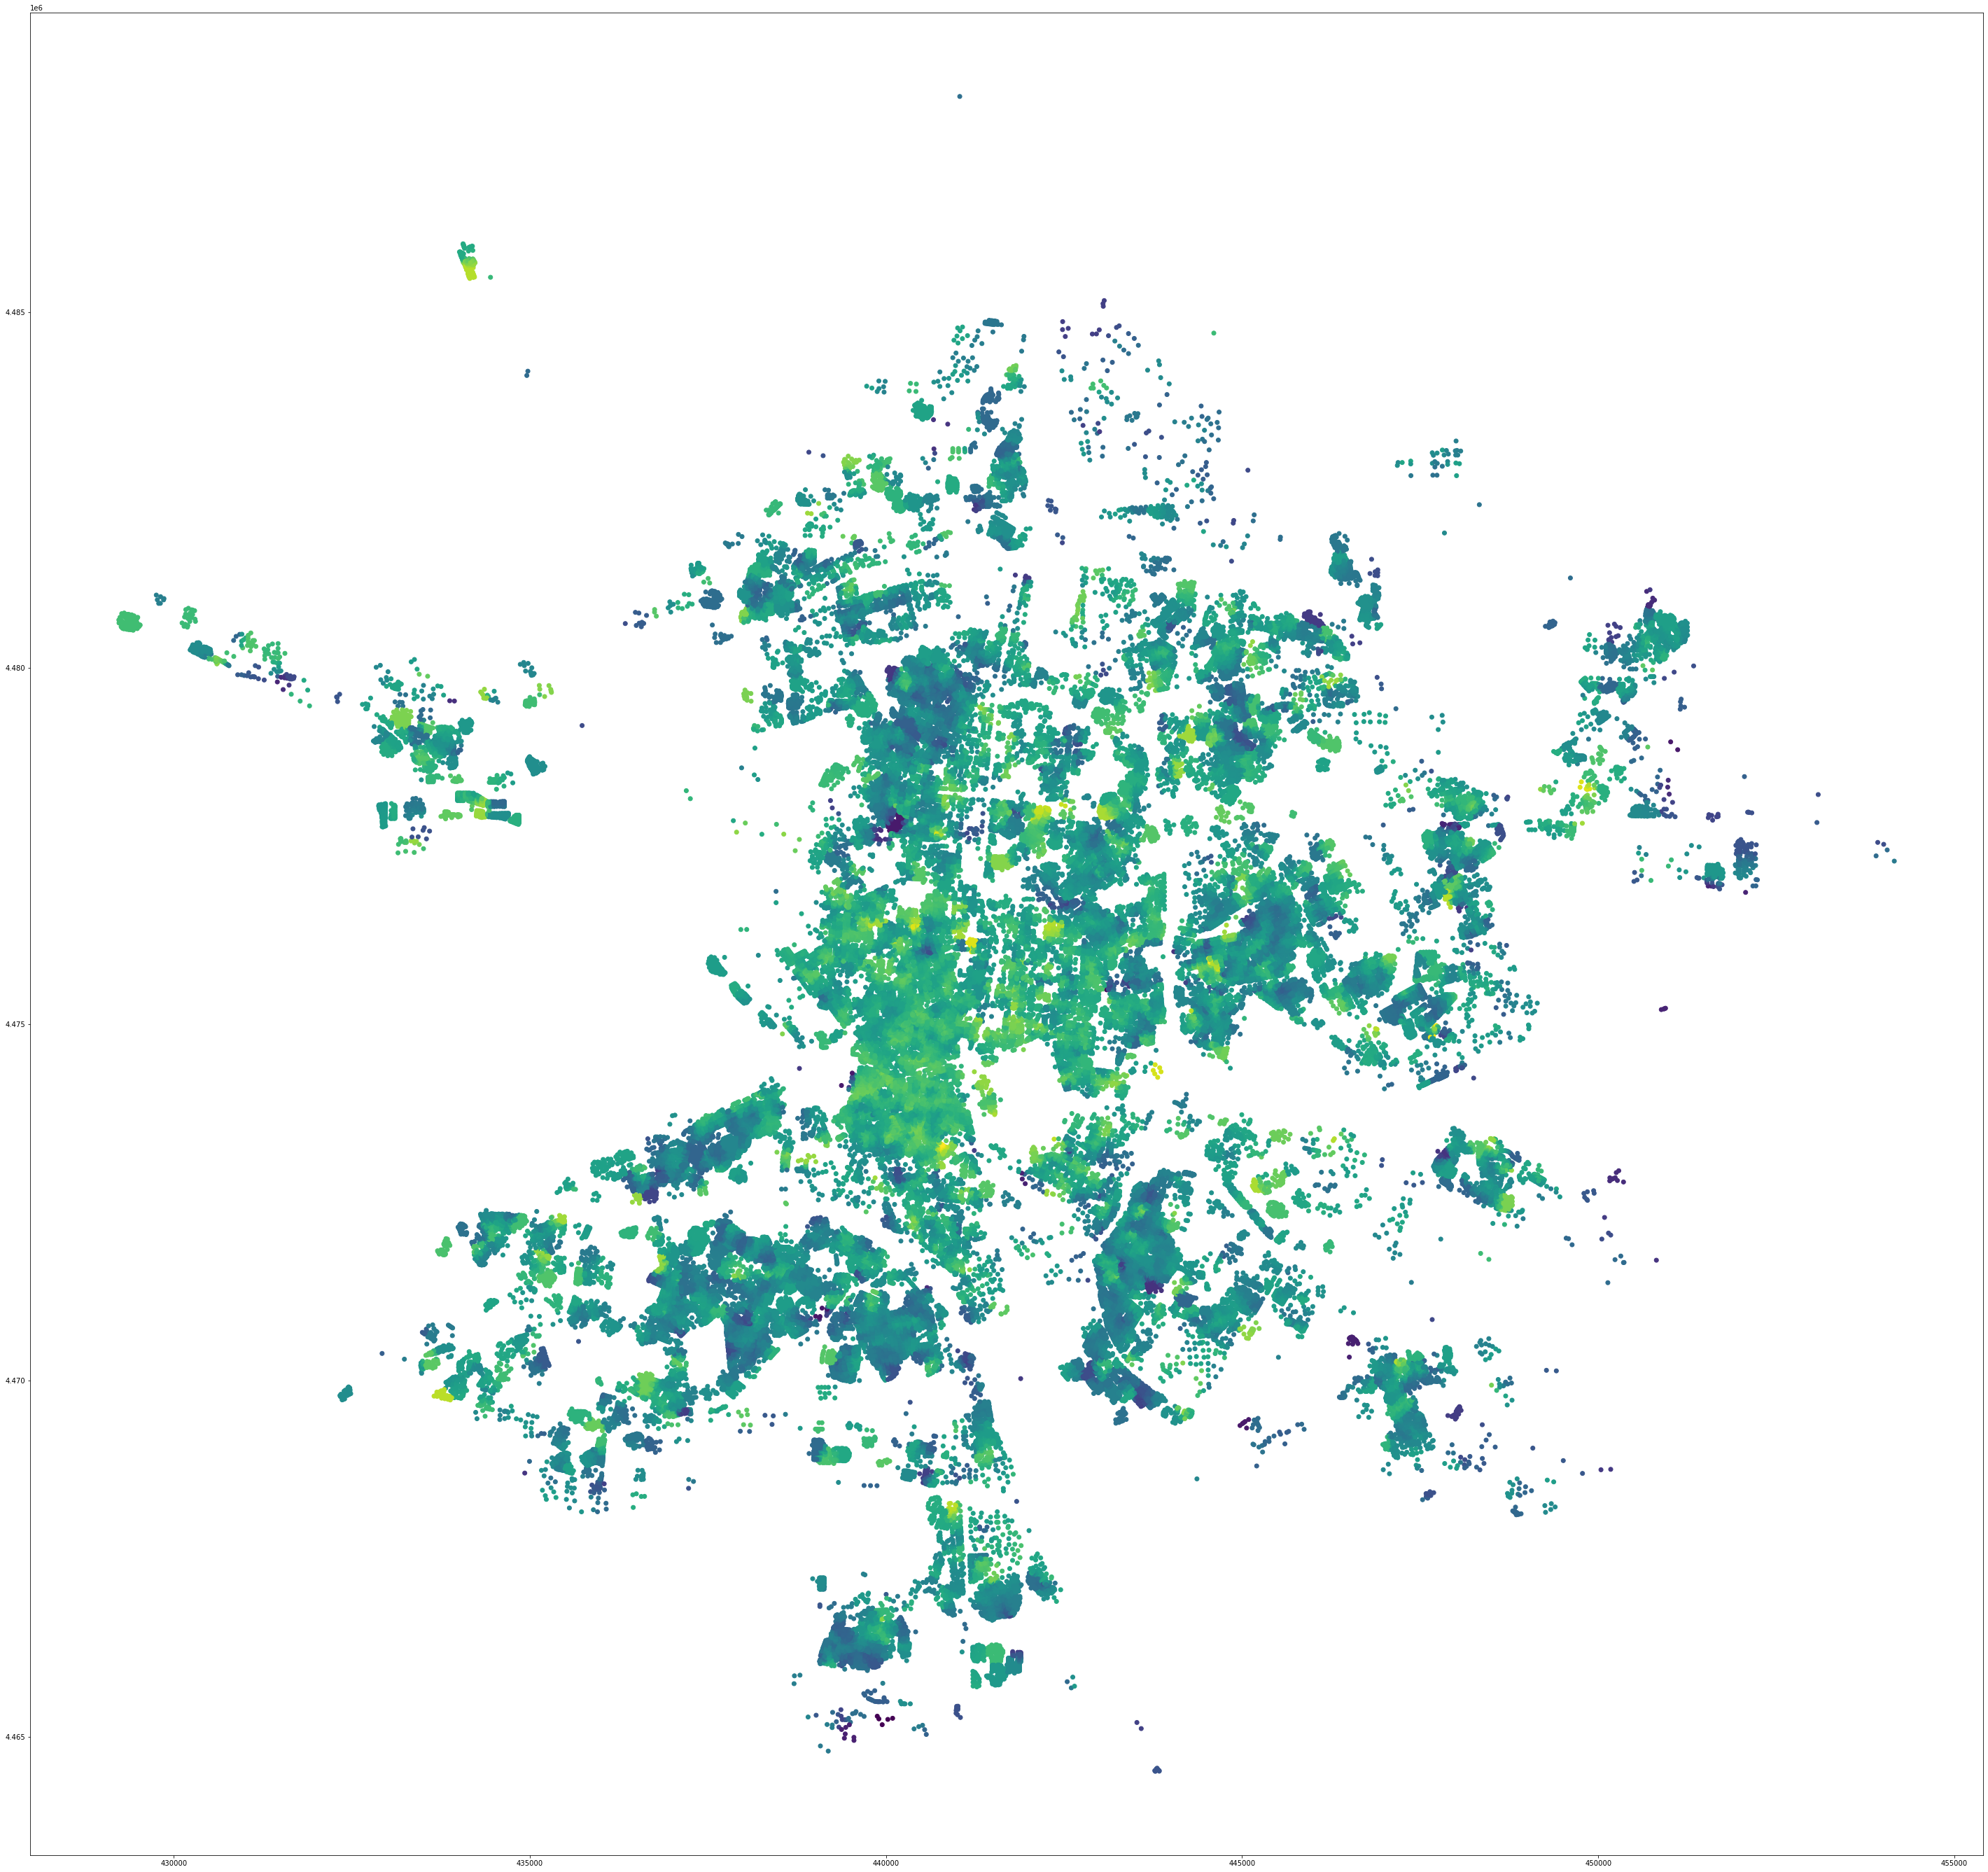

In [11]:
col_to_draw = 'value' # col value corresponds grossfloorarea
all_data[['geometry', col_to_draw]].plot(figsize = (50,75), column = col_to_draw)
plt.show()

## MODEL

Checklist:
- Categorical data to convert?
- Missing data to remove?
- Column collinearly - any high correlations?
- Column-wise data distribution - is the distribution skewed?
- Imbalanced data

In [12]:
# CATEGORICAL DATA
# columns that are 'object type'
# ------------------------------
# ID
# conditionOfConstruction
# currentUse
# yearOfConstruction

# NULL DATA 
# 350 nulls in currentUse
# column dm_id_num is pretty much null

In [13]:
# GETTING RID OF NULLS
filtr = all_data['currentUse'].notnull()

all_data = all_data.drop(['dm_id_num'], axis = 1)
all_data = all_data[filtr]

print(f"Checking there are no nulls in data: {sum(all_data.isna().sum().tolist()) == 0}")

Checking there are no nulls in data: True


In [14]:
# TRANSFORM YEAR
## this should be in first or second pipeline for Catastro data
    
all_data['centuryOfConstr'] = all_data.apply(lambda x: year_to_halfcentury(x['yearOfConstruction']), axis = 1)
all_data.drop(['yearOfConstruction'], axis = 1, inplace = True)

In [15]:
## Getting dummies and dropping cols
cat_cols = ['centuryOfConstr', 'currentUse', 'conditionOfConstruction']
cat_df = pd.get_dummies(all_data[cat_cols])
all_data = pd.concat([all_data, cat_df], axis = 1)
all_data.drop(cat_cols, axis = 1, inplace = True)

In [16]:
# ID as index 
# ID is a very useful col but it is categorical
# ID is unique for every urban parcel
# Also, it is not data that is interesting to take into consideration for clustering

all_data.set_index('ID', inplace = True)

In [17]:
all_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 92522 entries, 0002601VK4700A to 9999720VK4799H
Data columns (total 81 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   n_BuildingUnits                     92522 non-null  int64   
 1   n_Dwellings                         92522 non-null  int64   
 2   nFloors_AG                          92522 non-null  int64   
 3   nFloors_BG                          92522 non-null  int64   
 4   ID_part                             92522 non-null  int64   
 5   area_m2c                            92522 non-null  int64   
 6   area_m2p                            92522 non-null  int64   
 7   geometry                            92522 non-null  geometry
 8   train                               92522 non-null  float64 
 9   land_use_mix                        92522 non-null  float64 
 10  closeness_small_parks               92522 non-null  float64 
 11  res

## VISUALIZATION OF DAT

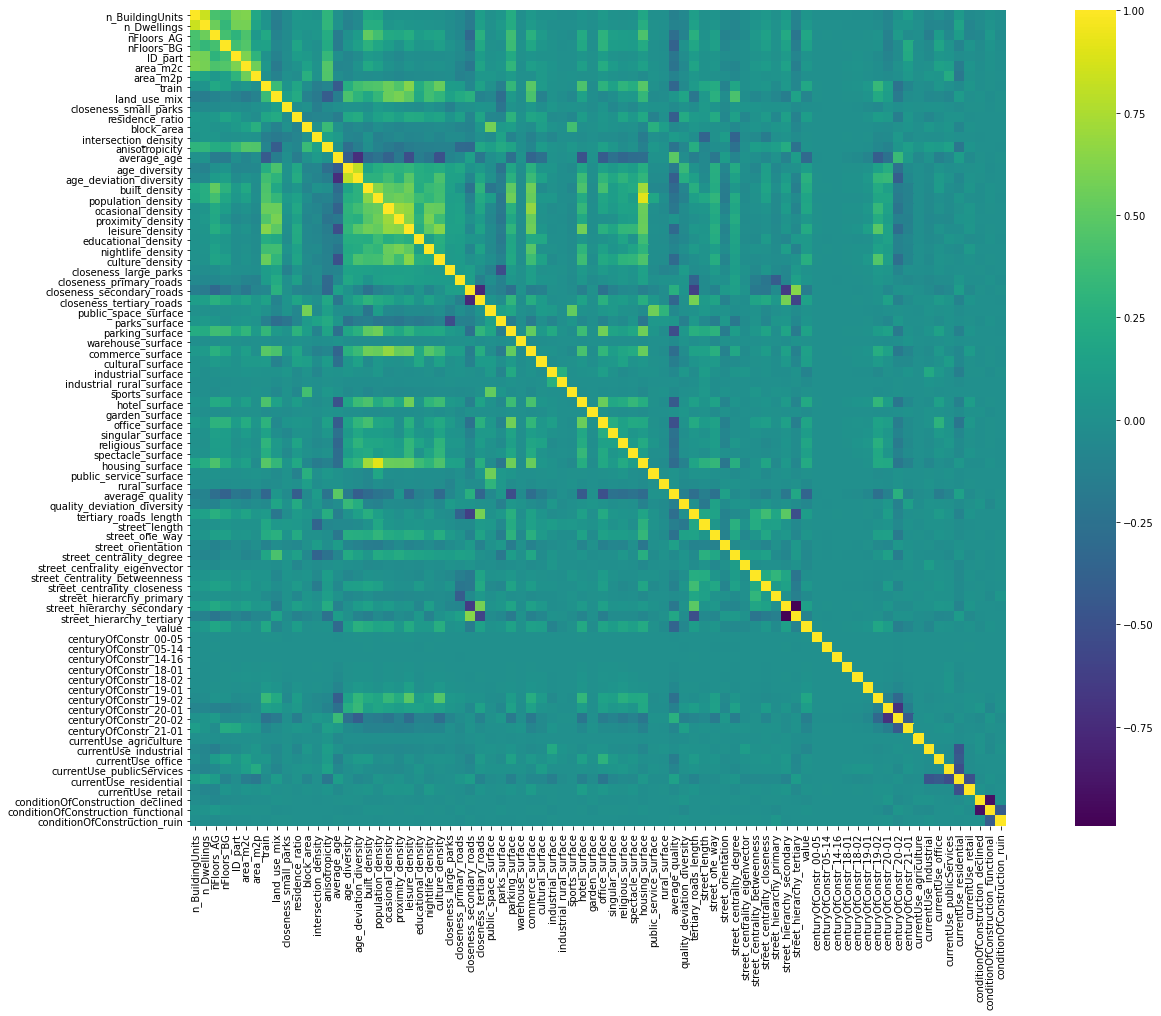

In [18]:
corr_matrix = all_data.corr()

fig, ax = plt.subplots(figsize = (25, 15))
ax = sns.heatmap(corr_matrix, cmap = 'viridis', square = True)

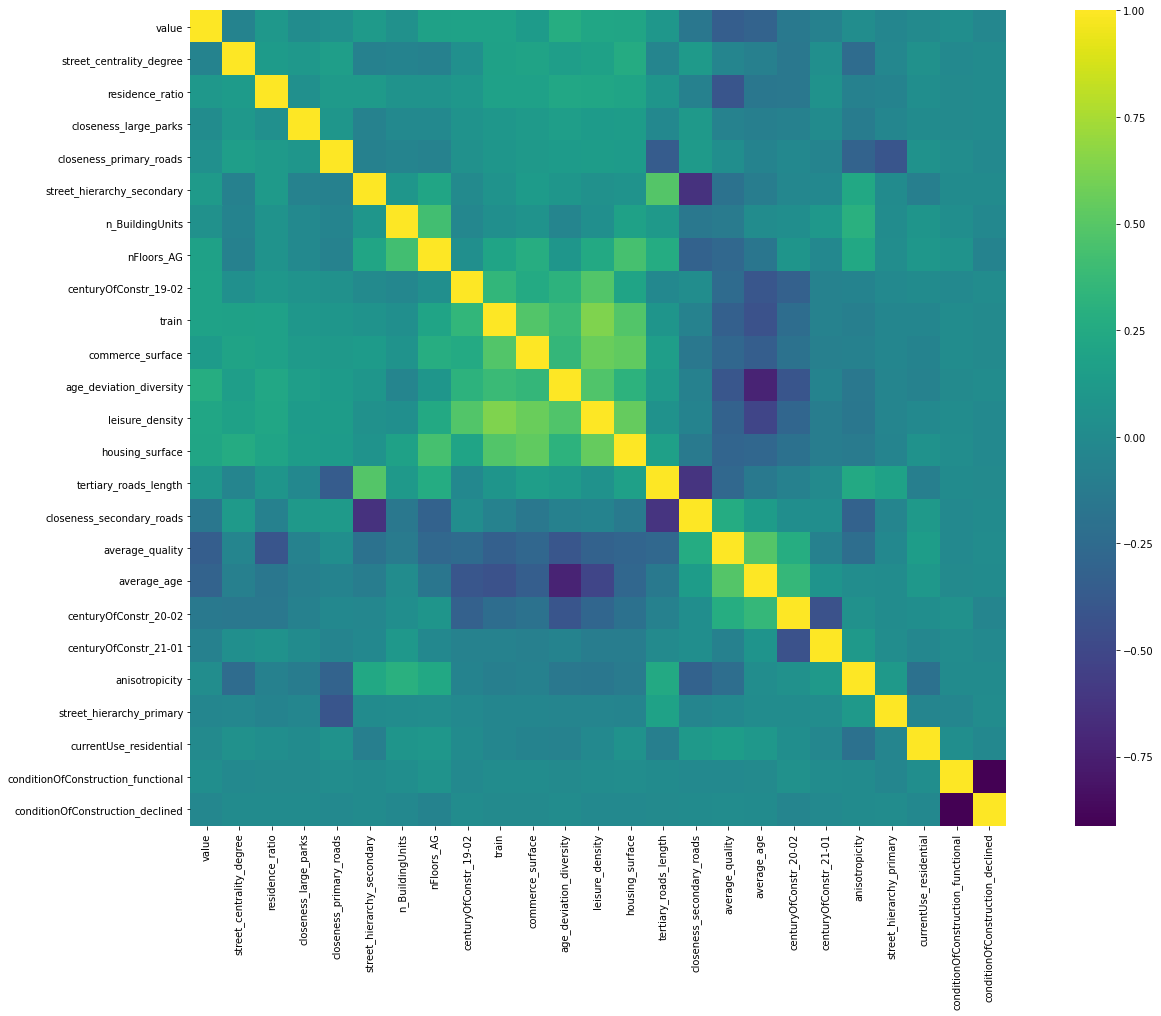

In [19]:
more_important_cols = ['value', 'street_centrality_degree', 'residence_ratio', 'closeness_large_parks', 
                       'closeness_primary_roads', 'street_hierarchy_secondary', 'n_BuildingUnits', 
                       'nFloors_AG', 'centuryOfConstr_19-02', 'train', 'commerce_surface',                     
                       'age_deviation_diversity', 'leisure_density', 'housing_surface', 
                      'tertiary_roads_length',  'closeness_secondary_roads', 'average_quality', 
                       'average_age', 'centuryOfConstr_20-02', 'centuryOfConstr_21-01', 'anisotropicity', 
                       'street_hierarchy_primary', 'currentUse_residential', 
                      'conditionOfConstruction_functional', 'conditionOfConstruction_declined']

corr_matrix = all_data[more_important_cols].corr()

fig, ax = plt.subplots(figsize = (25, 15))
ax = sns.heatmap(corr_matrix, cmap = 'viridis', square = True)

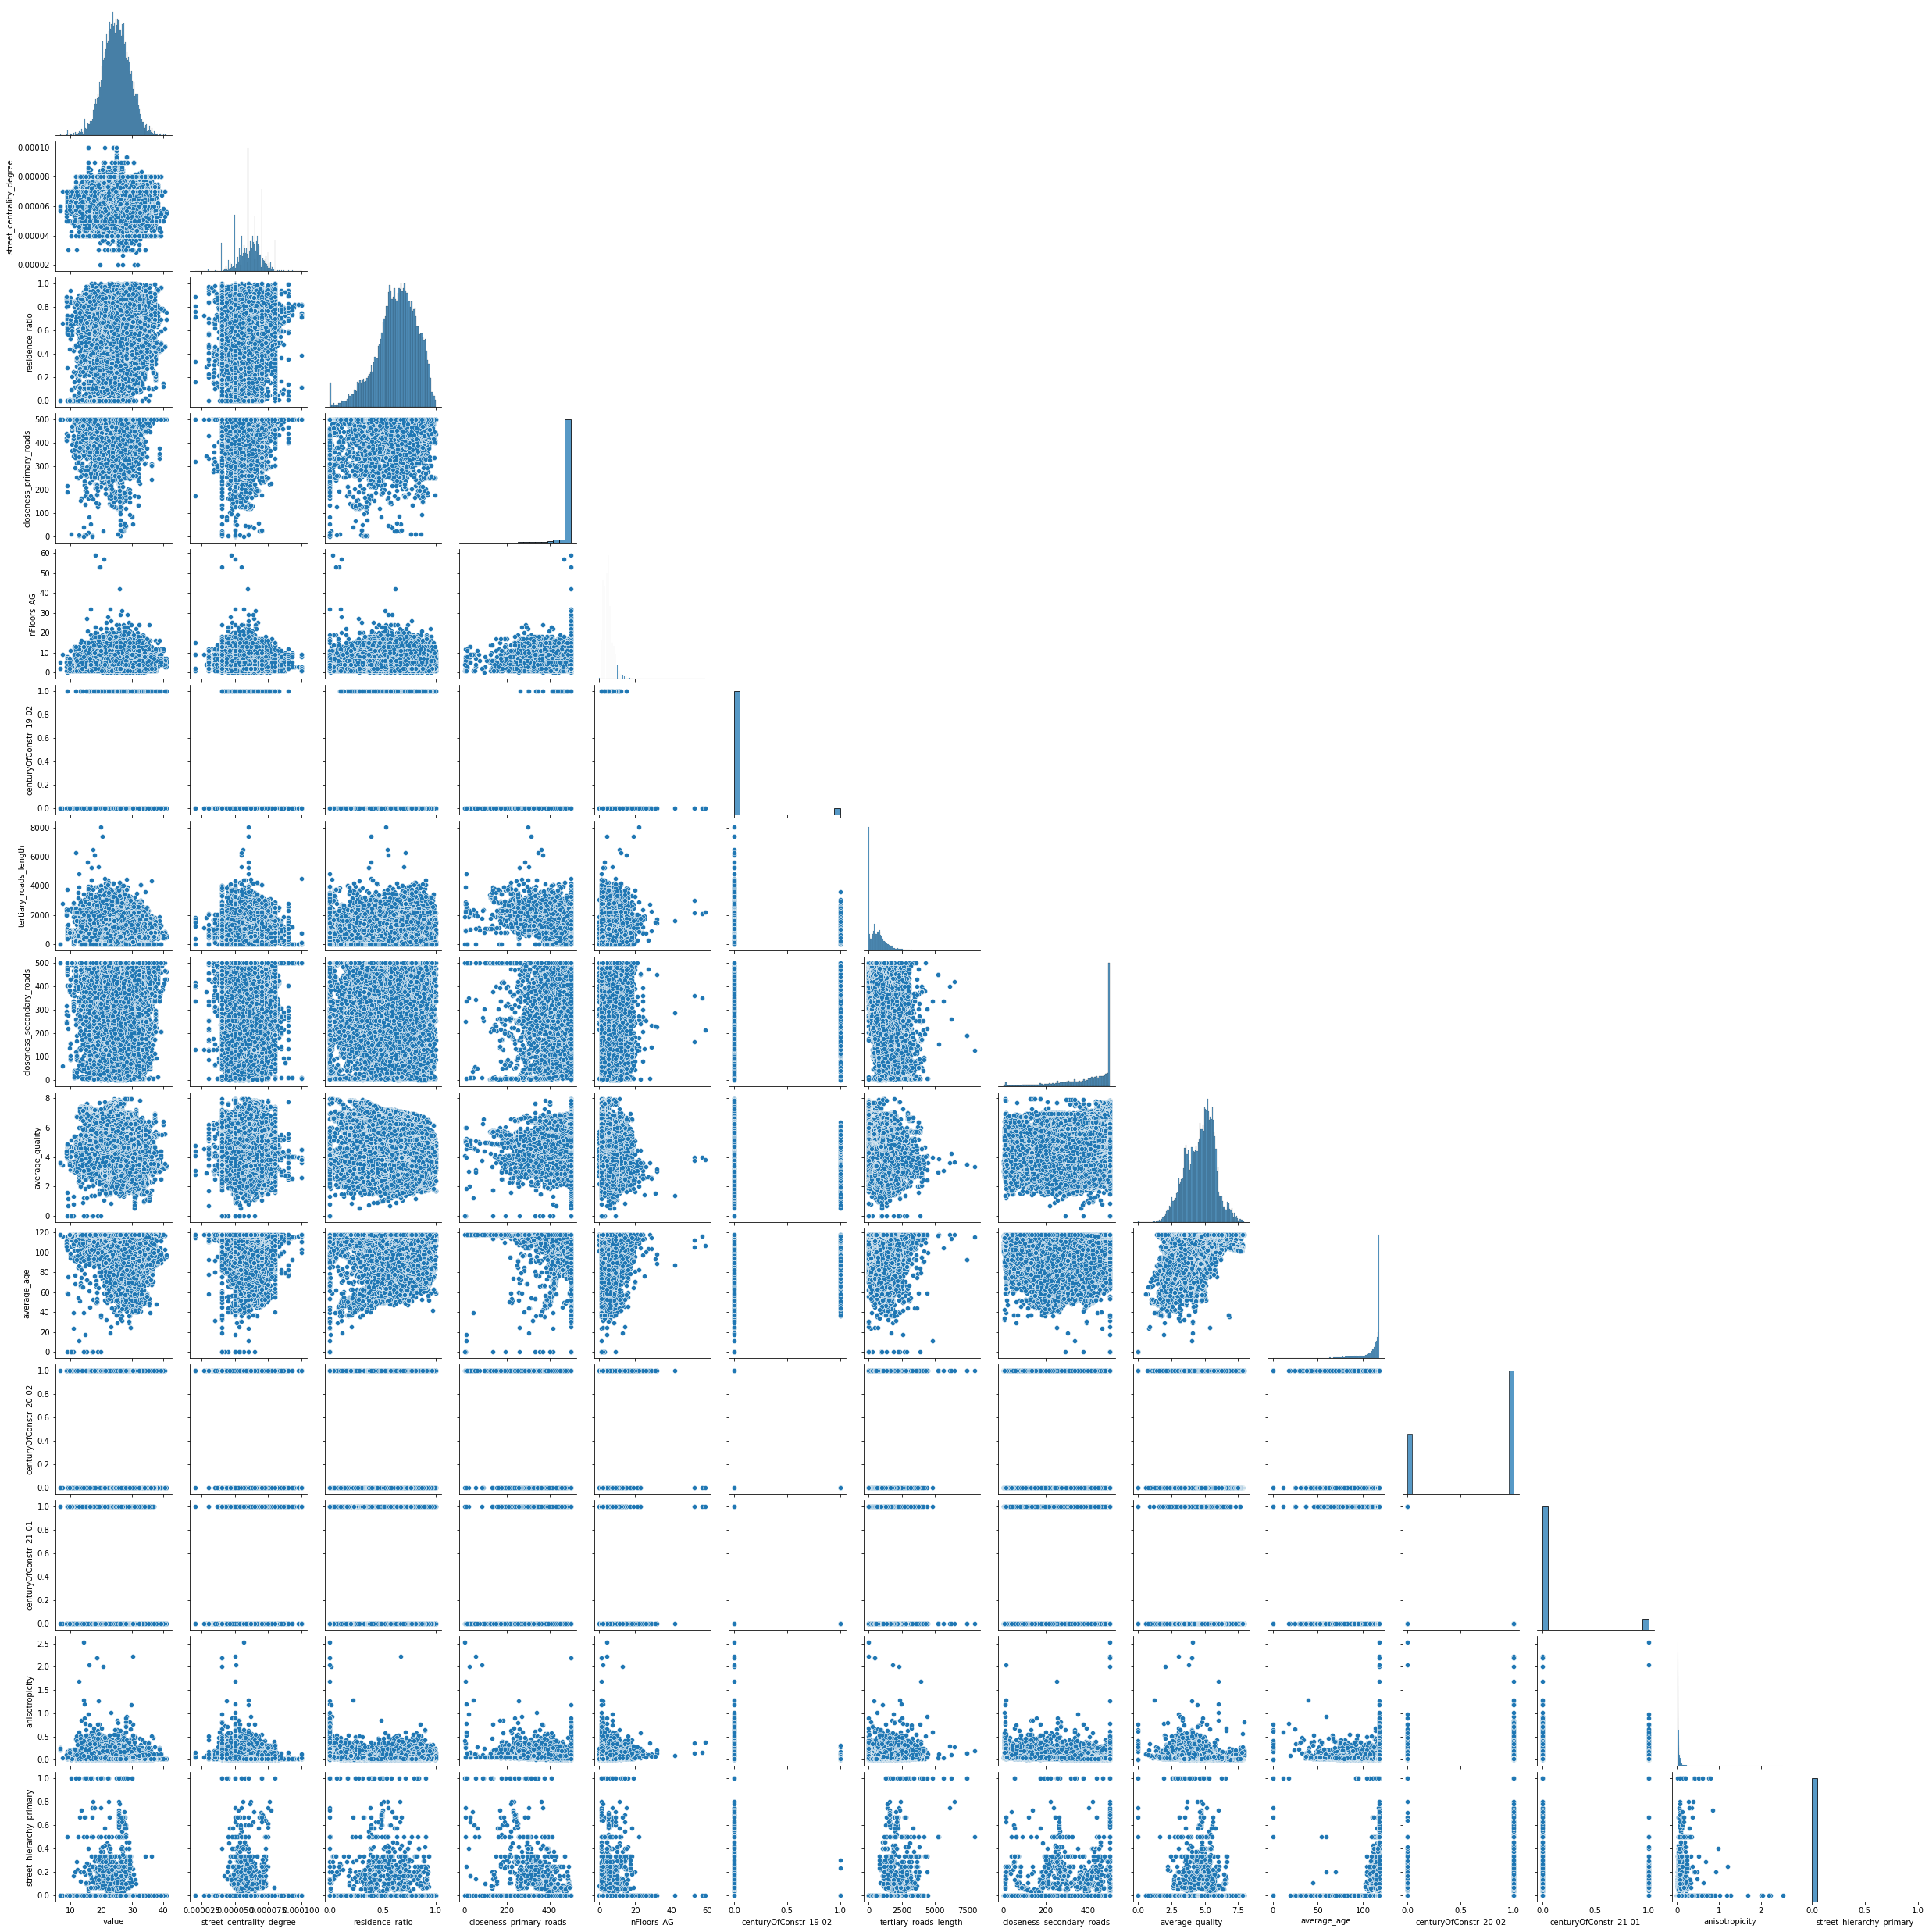

In [26]:
cols_resume = ['value', 'street_centrality_degree', 'residence_ratio', 'closeness_primary_roads', 
               'nFloors_AG', 'centuryOfConstr_19-02', 'tertiary_roads_length', 
               'closeness_secondary_roads', 'average_quality', 'average_age', 'centuryOfConstr_20-02', 
               'centuryOfConstr_21-01', 'anisotropicity', 'street_hierarchy_primary']

sns.pairplot(all_data[cols_resume], corner = True)

plt.show()

In [27]:
all_data.head()

n_BuildingUnits  n_Dwellings  nFloors_AG  nFloors_BG  ID_part  \
ID                                                                              
0002601VK4700A               16           16          10           0        4   
0002602VK4700A               16           16          10           0        4   
0002603VK4700A               16           16          10           0        4   
0002604VK4700A               16           16          10           0        4   
0002605VK4700A               16           16          10           0        4   

                area_m2c  area_m2p                        geometry     train  \
ID                                                                             
0002601VK4700A      1809       199  POINT (439951.830 4470056.850)  0.300000   
0002602VK4700A      1809       199  POINT (439961.160 4470043.370)  0.222222   
0002603VK4700A      1809       199  POINT (439970.490 4470029.880)  0.285714   
0002604VK4700A      1809       199  POINT (439979.830 4470016.390)  0.000000   
0002605VK4700A      1809       199  POINT (439989.160 4470002.910)  0.000000   

                land_use_mix  ...  centuryOfConstr_21-01  \
ID                            ...                          
0002601VK4700A      0.000235  ...                      0   
0002602VK4700A      0.000235  ...                      0   
0002603VK4700A      0.000227  ...                      0   
0002604VK4700A      0.000183  ...                      0   
0002605VK4700A      0.000141  ...                      0   

                currentUse_agriculture  currentUse_industrial  \
ID                                                              
0002601VK4700A                       0                      0   
0002602VK4700A                       0                      0   
0002603VK4700A                       0                      0   
0002604VK4700A                       0                      0   
0002605VK4700A                       0                      0   

                currentUse_office  currentUse_publicServices  \
ID                                                             
0002601VK4700A                  0                          0   
0002602VK4700A                  0                          0   
0002603VK4700A                  0                          0   
0002604VK4700A                  0                          0   
0002605VK4700A                  0                          0   

                currentUse_residential  currentUse_retail  \
ID                                                          
0002601VK4700A                       1                  0   
0002602VK4700A                       1                  0   
0002603VK4700A                       1                  0   
0002604VK4700A                       1                  0   
0002605VK4700A                       1                  0   

                conditionOfConstruction_declined  \
ID                                                 
0002601VK4700A                                 0   
0002602VK4700A                                 0   
0002603VK4700A                                 0   
0002604VK4700A                                 0   
0002605VK4700A                                 0   

                conditionOfConstruction_functional  \
ID                                                   
0002601VK4700A                                   1   
0002602VK4700A                                   1   
0002603VK4700A                                   1   
0002604VK4700A                                   1   
0002605VK4700A                                   1   

                conditionOfConstruction_ruin  
ID                                            
0002601VK4700A                             0  
0002602VK4700A                             0  
0002603VK4700A                             0  
0002604VK4700A                             0  
0002605VK4700A                             0  

[5 rows x 81 columns]

## PREPROCESSING and DIMENSION REDUCTION

In [28]:
from sklearn.preprocessing import StandardScaler
cols_df = [col for col in all_data.columns if col != 'geometry']

scaler = StandardScaler()
# Standarization --> rescaling to mean == 0 and Std.Dev == 1

geodata_scale = scaler.fit_transform(all_data[cols_df])

In [30]:
import umap

reducer = umap.UMAP(random_state = STATE)
reducer.fit(geodata_scale)

embedding = reducer.transform(geodata_scale)

/home/lucia/miniconda3/envs/geoesp_env/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


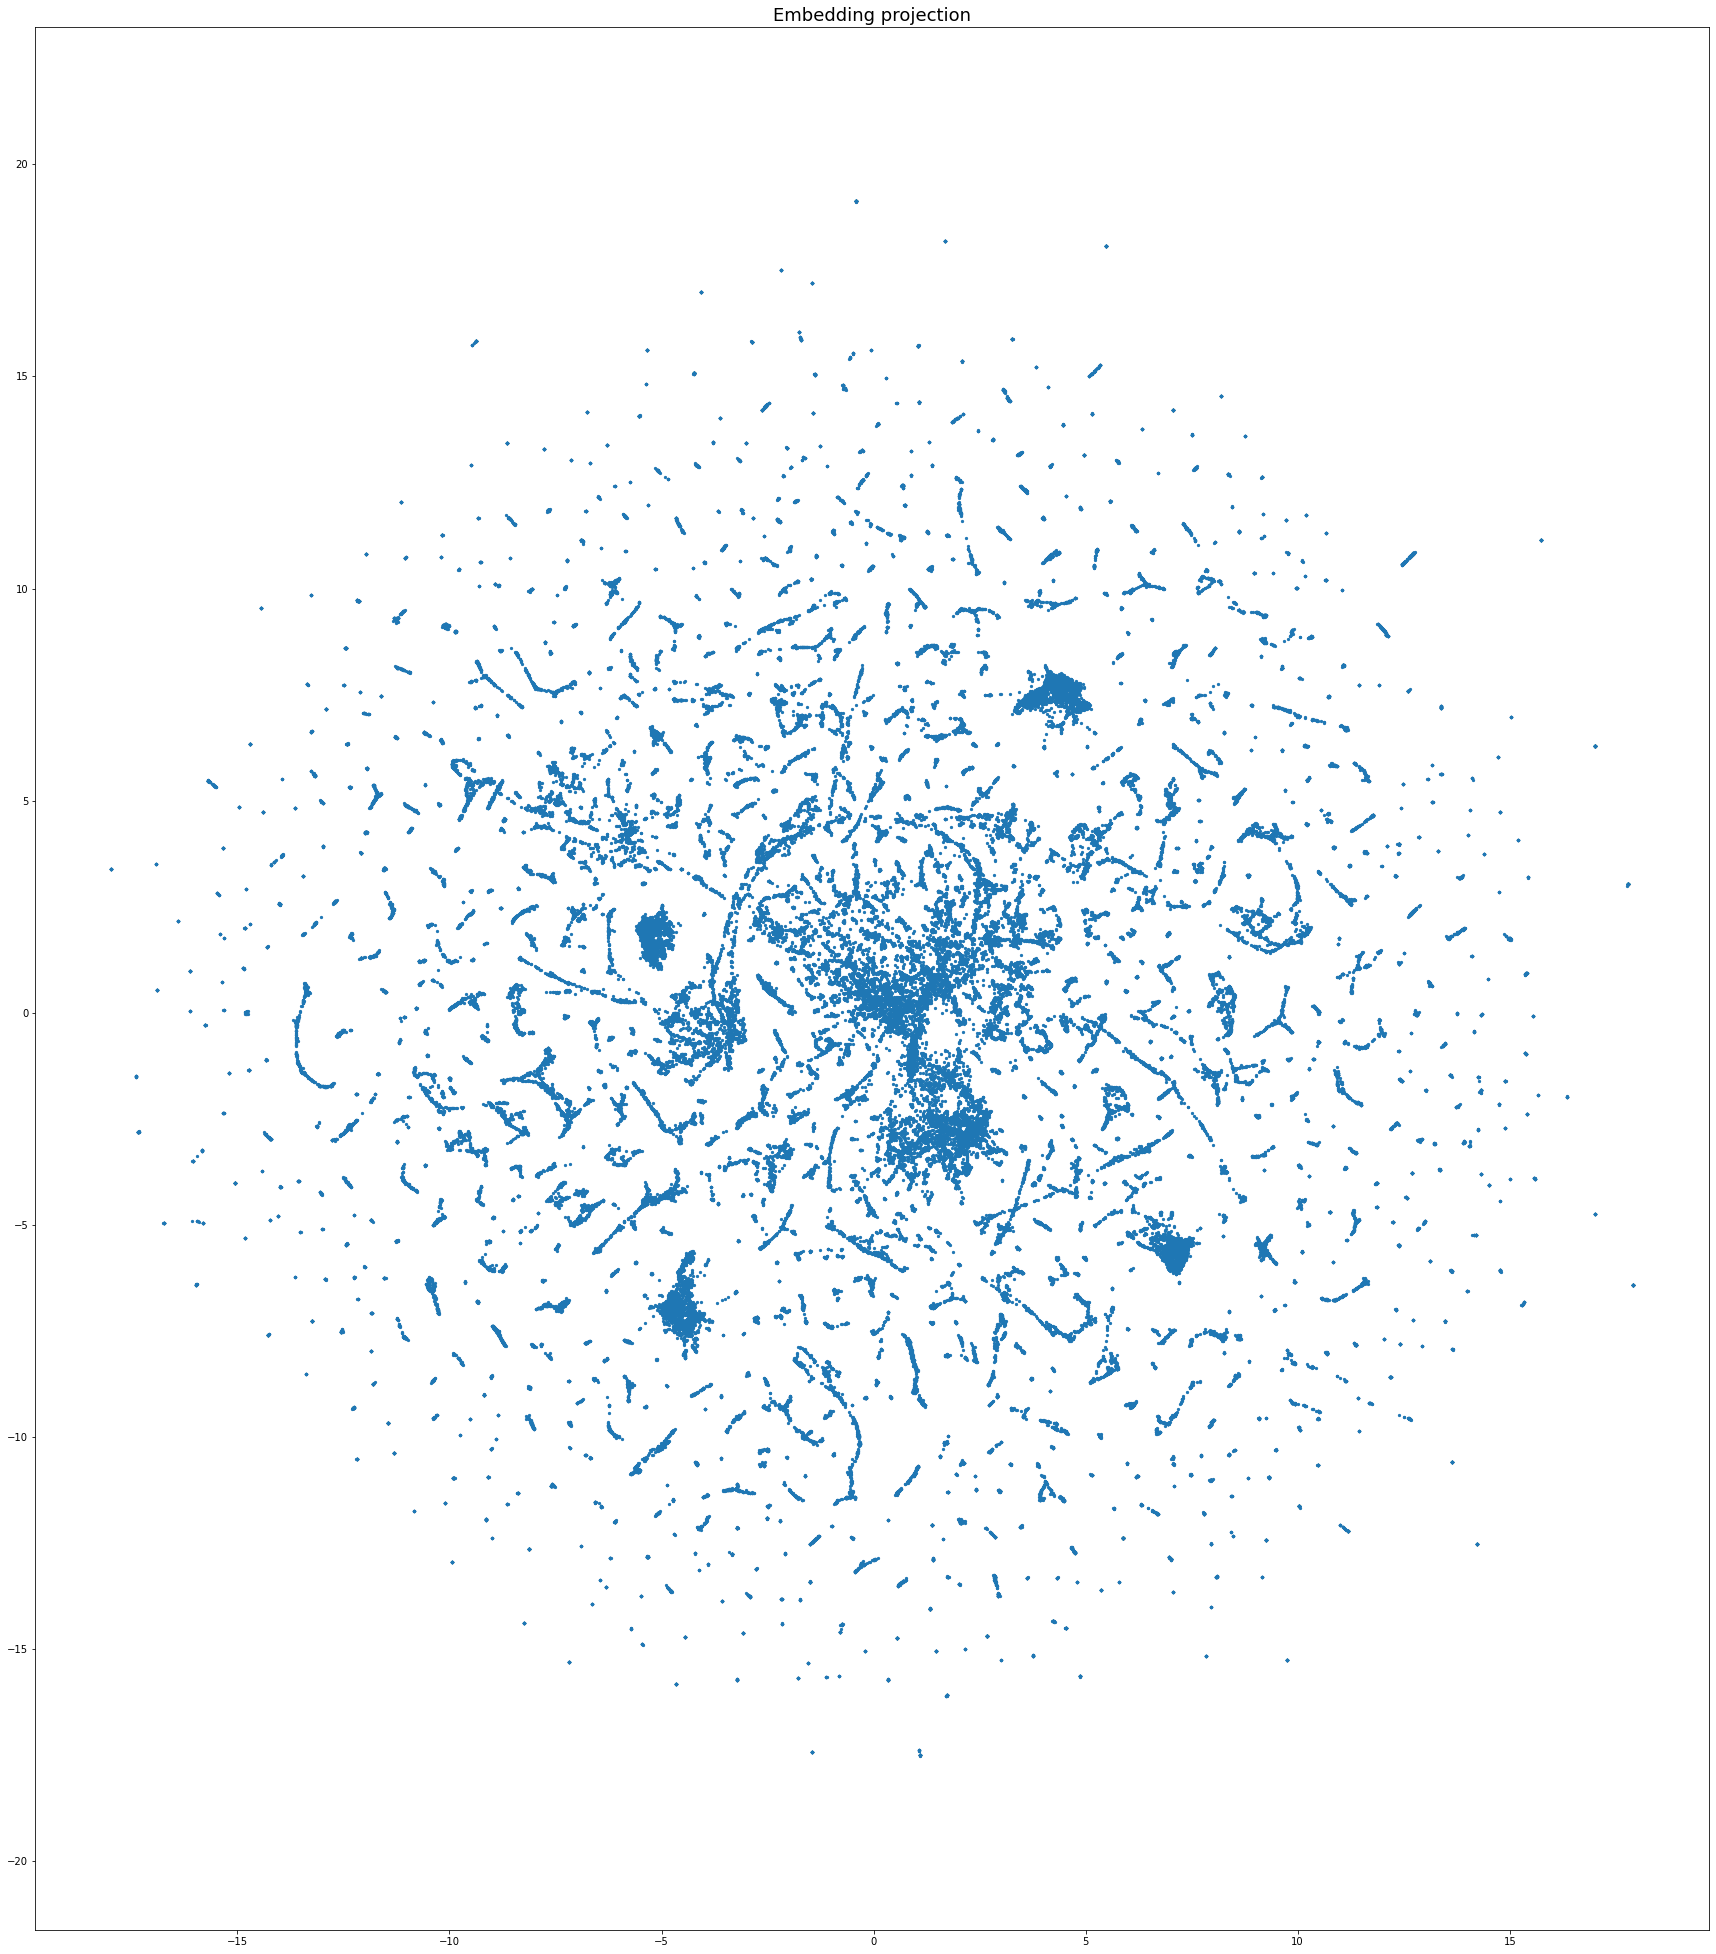

In [34]:
plt.figure(figsize = (30,35))
plt.scatter(x = embedding[:, 0], 
            y = embedding[:, 1], 
            s = 5)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Embedding projection', fontsize=18);

## MODELLING

>- KMeans: aims to partition the observations into a predifined number of clusters(k) in which each point belong to the cluster with the nearest mean. It starts by randomly selecting k centroinds ans assignin the points to the clustest cluster, then it updates each centroid with the mean of all points in the cluster.
    >- 
>- DMSCAN
>- Agglomerative clustering


#### 1. KMEANS

Para conocer el número de clusters que se necesita, se

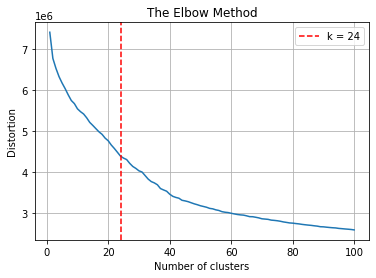

In [41]:
from sklearn.cluster import KMeans
max_k = 100

## make list with inertia
distortions = [] 
for i in range(1, max_k+1):
    model = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = STATE)
    model.fit(geodata_scale)
    distortions.append(model.inertia_)
        
        
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)]\
            .index(min([i*100 for i in np.diff(distortions, 2)]))
## plot
fig, ax = plt.subplots(figsize = (25,15))

ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', 
       xlabel='Number of clusters', 
       ylabel="Distortion")

ax.legend()
ax.grid(True)
plt.show()

In [42]:
km_model = KMeans(n_clusters = 30, random_state = STATE, max_iter = 300, n_init = 10).fit(geodata_scale)

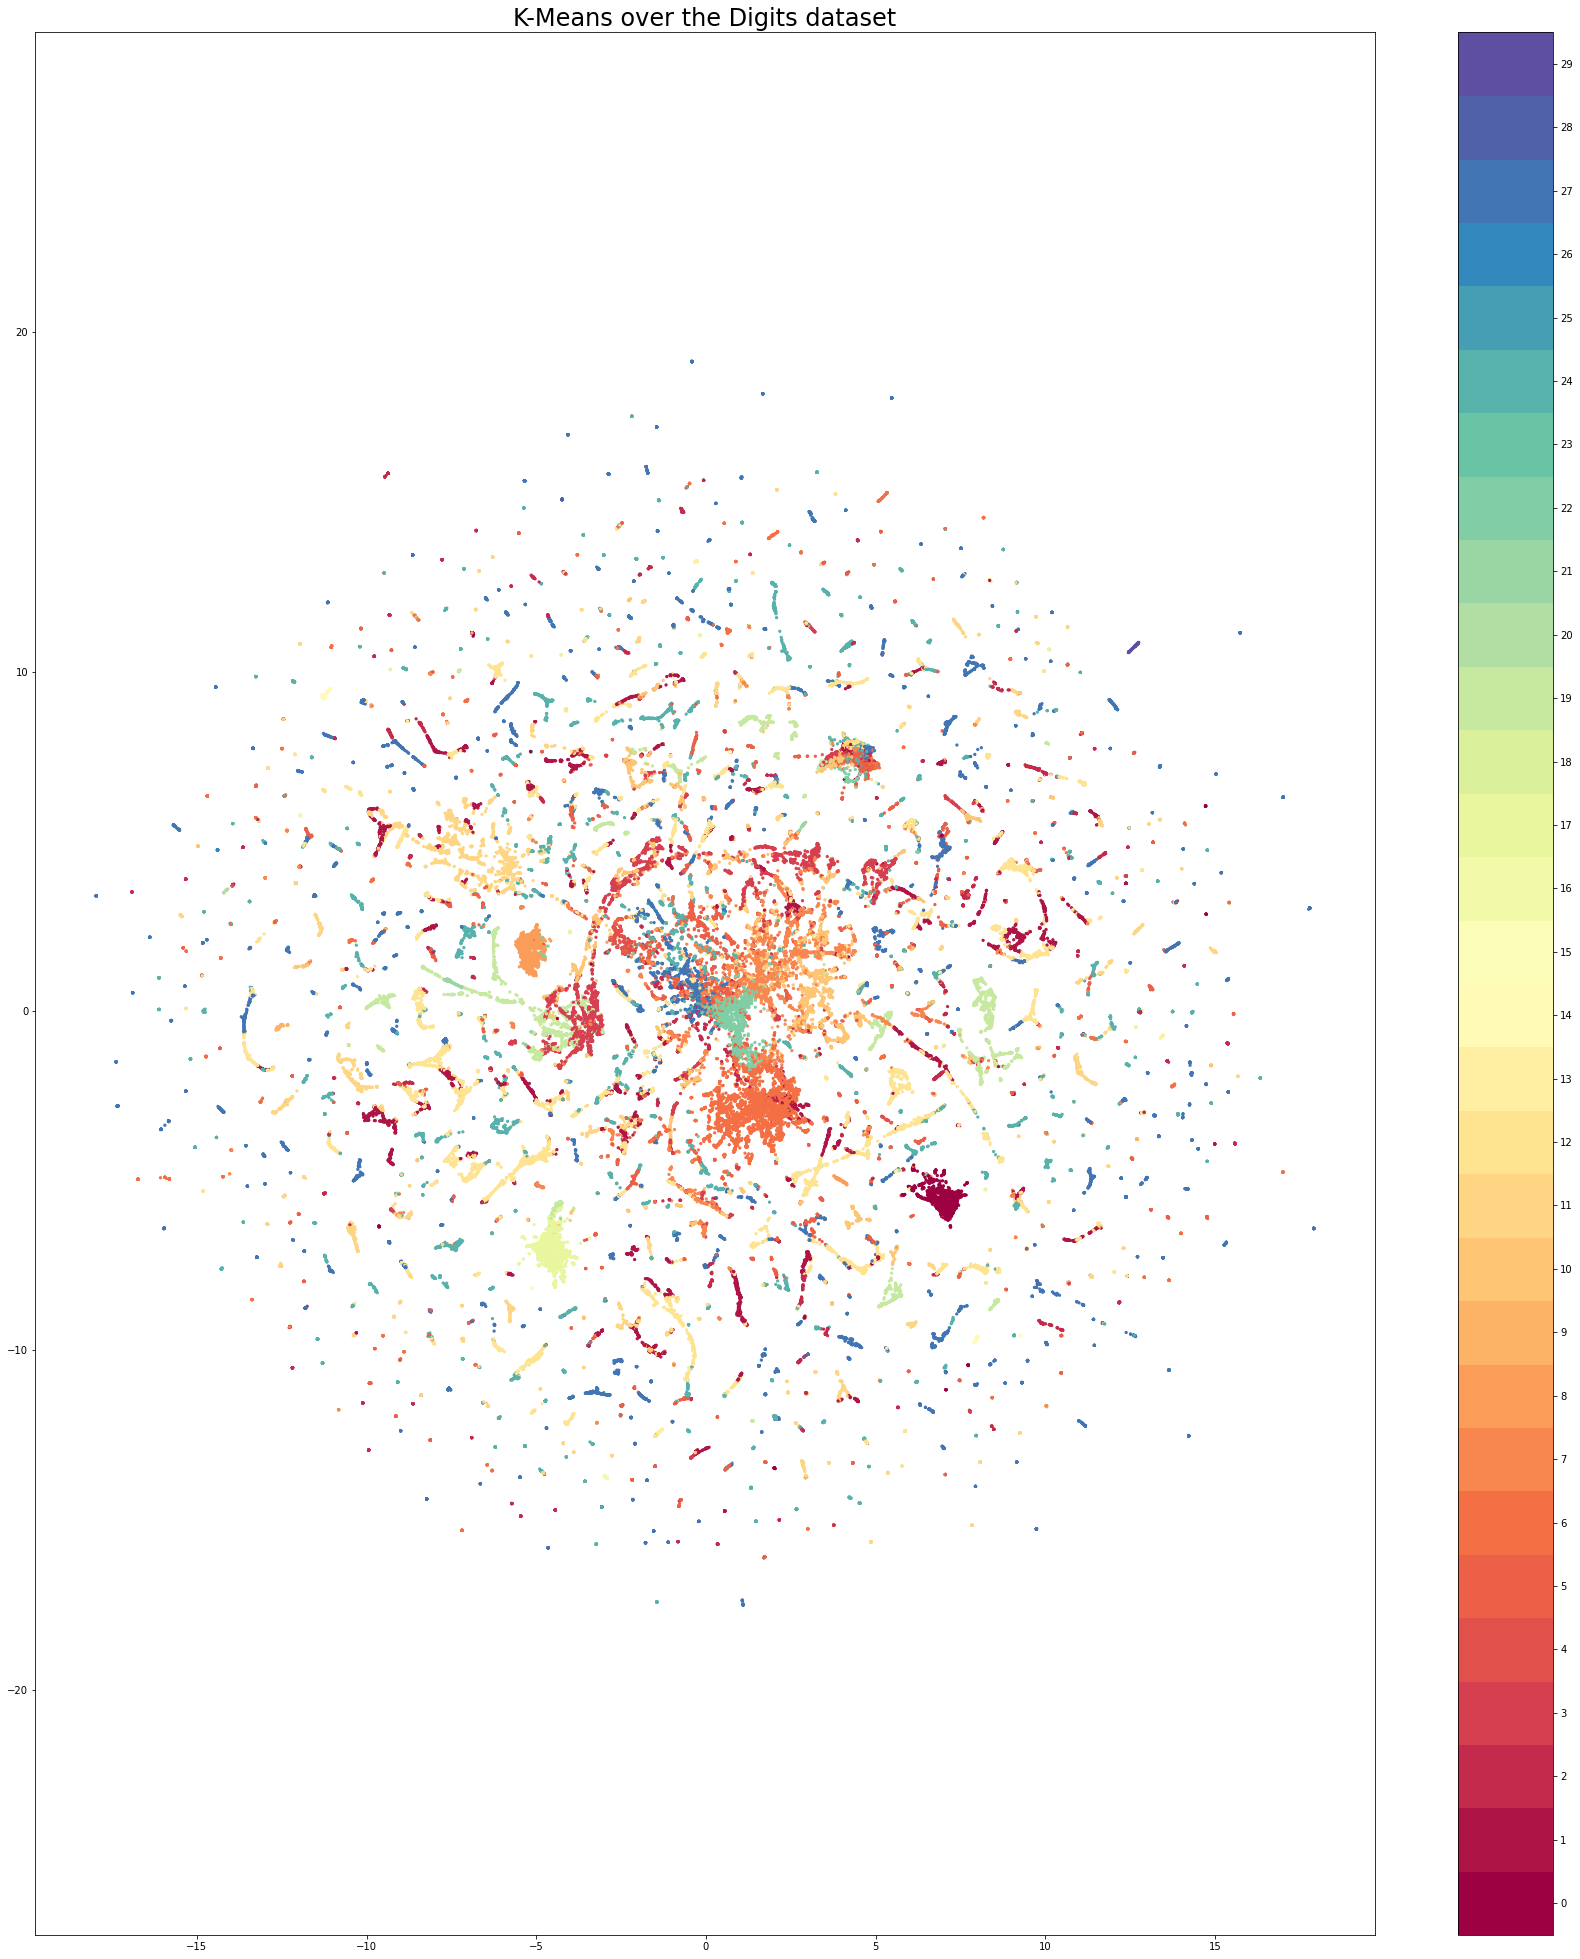

In [46]:
plt.figure(figsize = (30,35))

plt.scatter(embedding[:, 0], 
            embedding[:, 1], 
            c = km_model.labels_, 
            cmap = 'Spectral', 
            s = 5)

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries = np.arange(km_model.n_clusters + 1) - 0.5)\
                            .set_ticks(np.arange(km_model.n_clusters))

plt.title('K-Means over the Digits dataset', fontsize=24);

In [ ]:
col_to_draw = 'value' # col value corresponds grossfloorarea
all_data[['geometry', col_to_draw]].plot(figsize = (50,75), column = col_to_draw)
plt.show()